# Data Preprocessing + Loading for Model

In [2]:
### Imports
import os 
import json
import cv2
import numpy as np
import clip
import torch
from PIL import Image
from tqdm import tqdm
import jsonlines
import json_numpy

/home/kastan/utils/miniconda3/envs/nlp_v2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
### Installs
# ! pip install git+https://github.com/openai/CLIP.git cog mmcv mmcv-full==1.4.3 -f https://download.openmmlab.com/mmcv/dist/cu101/torch1.7.0/index.html
# ! pip install cog
# ! pip uninstall mmcv
# ! pip install mmcv-full==1.4.3 -f https://download.openmmlab.com/mmcv/dist/cu101/torch1.7.0/index.html


## Data preprocessing

Code to create each training sample and save each sample as a npy file.
Npy file is a dict of the following format:

```
{
  "youtube_name": "2ZokZgnjrYs",                      
  "filename": video_name,                      
  "youtube_id": "Hawaii Vlog",                         
  "segment_length_seconds": 15.0,
  "captions": "Daniel's chosen format here",           
  "segment_start_time":[<segment_start_times_list>],
  "segment_end_time":[<segment_end_times_list>],     
  "frame_embeddings":[<frame_embeddings_list>],        
  "audio_embeddings":[<audio_embeddings_list>],        
  "text_caption_embeddings":[<text_embeddings_list>],  
  "scene_graph_embeddings":[<scene_graph_embeddings_list>],     
  # "labels": [<labels_list>],                       
}
```


### Preprocessed Whisper File Format

The preprocessed Whisper files are of the following format:

```
[
    {
        'caption': "some-caption-1",
        'start': caption_start_time,
        'end': caption_end_time, 
        'segment_word_list': [{'word': 'some-word', 'start': word_start_time, 'end': word_end_time}, ...]
    },
    {
        'caption': "some-caption-2",
        'start': caption_start_time,
        'end': caption_end_time, 
        'segment_word_list': [{'word': 'some-word', 'start': word_start_time, 'end': word_end_time}, ...]
    },
    ...
]
```

To use the `DataPreprocessor` class, instantiate it with the data path to the folder containing .webm videos and the data path containing the Whisper extracted json files. Also, make sure you set the extension to `".webm"`. Then, simply call `process_using_audio_dir` with the desired output path to store the npy files. Each npy file corresponds to a single sample i.e. a single segment extracted from a video. The naming convention for the npy files is the following format: `{video_name}_segment{segment_number}.npy`. 


Example usage: 


```
data_preprocessor = DataPreprocessor(video_data_path="/mnt/storage_ssd/yt1b_train_slice/", audio_data_path="/mnt/storage_ssd/yt1b_train_slice_json/", extension=".webm")
data_preprocessor.process_using_audio_dir("./test_sample_generation")
```

In [2]:
class DataPreprocessor: 
    def __init__(self, video_data_path, audio_data_path, extension=".mp4", debug=True):
        self.video_data_path = video_data_path
        self.audio_data_path = audio_data_path
        self.extension = extension
        self.debug = debug

        # Load the model
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        if self.debug:
            print(f"Using {self.device}...")

        self.clip, self.clip_preprocess = clip.load('ViT-B/32', self.device)

        if self.debug:
            print(f"Done setting up CLIP...")

        # self.scene_graph_predictor = Predictor()
        # self.scene_graph_predictor.setup()


    def get_frames_for_segments(self, video_name, segments):
        if len(segments) == 0:
            return None
        
        curr_segment_idx = 0
        curr_segment_start = segments[0]['start']
        curr_segment_end = segments[0]['end']

        segment_frames = [[] for i in range(len(segments))]

        assert os.path.exists(self.video_data_path+video_name+self.extension)

        cap = cv2.VideoCapture(self.video_data_path+video_name+self.extension)
        fps = cap.get(cv2.CAP_PROP_FPS)

        frame_width = int(cap.get(3))
        frame_height = int(cap.get(4))
        
        size = (frame_width, frame_height)

        timestamps = [cap.get(cv2.CAP_PROP_POS_MSEC)]
        curr_timestamp = 0.0

        segments_done = False

        while(cap.isOpened()):
            frame_exists, curr_frame = cap.read()
            
            if frame_exists:
                curr_timestamp = cap.get(cv2.CAP_PROP_POS_MSEC)
                timestamps.append(curr_timestamp)

                if (curr_timestamp/1000.0) < curr_segment_start:
                    continue

                else:
                    if (curr_timestamp/1000.0) < curr_segment_end:
                        segment_frames[curr_segment_idx].append(curr_frame)
                    else:
                        curr_segment_start = segments[curr_segment_idx]['start']
                        curr_segment_end = segments[curr_segment_idx]['end']
                        while True:
                            if ((curr_timestamp/1000.0) > curr_segment_start) and ((curr_timestamp/1000.0) < curr_segment_end):
                                break

                            if (curr_timestamp/1000.0) < curr_segment_start:
                                break

                            curr_segment_idx += 1
                            if curr_segment_idx >= len(segments):
                                # print("segments done hit")
                                segments_done = True
                                break
                        
                            curr_segment_start = segments[curr_segment_idx]['start']
                            curr_segment_end = segments[curr_segment_idx]['end']

                        if segments_done:
                            break
                
            else:
                break

        cap.release()
        print(min(timestamps), max(timestamps))

        return segment_frames
        

    def get_multimodal_features(self, video_name, segments):
        segment_frames = self.get_frames_for_segments(video_name, segments)
        # scene_graph_features = []
        clip_features = []
        caption_features = []


        # extract clip features for each segment  and extract text features for captions
        for i, frames_list in enumerate(segment_frames):
            if len(frames_list) == 0:
                continue

            # TODO: extract scene graph features for each segment
            # scene_graph = self.scene_graph_predictor.predict(frames_list[0], num_rel=10)

            middle_frame_idx = len(frames_list) // 2
            sample_frame_idxs = [middle_frame_idx]

            resized_frames = [Image.fromarray(cv2.resize(frames_list[frame_idx], dsize=(224, 224), interpolation=cv2.INTER_CUBIC)) for frame_idx in sample_frame_idxs]

            image_input = torch.cat([self.clip_preprocess(frame).unsqueeze(0) for frame in resized_frames]).to(self.device)
            text_inputs = torch.cat([clip.tokenize(segments[i]['caption'])]).to(self.device)
        
            with torch.no_grad():
                image_features = self.clip.encode_image(image_input)
                text_features = self.clip.encode_text(text_inputs)

                clip_features.append(image_features)
                caption_features.append(text_features)

        return clip_features, caption_features, segment_frames


    def construct_training_samples(self, video_name, output_path):
        # initialize empty sample
        whisper_segments = None
        with open(self.audio_data_path+video_name+".json", "r") as whisper_f:
            whisper_segments = json.load(whisper_f)

        image_features, caption_features, segment_frames = self.get_multimodal_features(video_name, whisper_segments)

        # assert len(image_features) == len(scene_graph_features) == len(caption_features) == len(whisper_segments)
        
        for i, (image_feature, caption_feature, segment_frames) in enumerate(zip(image_features, caption_features, segment_frames)):
            sample_dict = {
                "filename": video_name,
                "segment_length": whisper_segments[i]['end'] - whisper_segments[i]['start'],
                "captions": whisper_segments[i]['caption'],
                "segment_start_time": whisper_segments[i]['start'],
                "segment_end_time": whisper_segments[i]['end'],
                "frame_embeddings": image_feature,
                "text_caption_embeddings": caption_feature,
                # "scene_graph_embeddings": scene_graph_feature
                "segment_frames": segment_frames
            }

            # TODO: Uncomment this code to start saving the files
            # np.save(os.path.join(output_path, f"{video_name}_segment{i}"), sample_dict)

        if self.debug:
            print("Constructed training samples")
            
    def process_using_audio_dir(self, output_path):
        samples_not_found = 0
        total_samples = 0

        if not os.path.exists(output_path):
            # Create a new directory because it does not exist
            os.makedirs(output_path)

        all_whisper_files = os.listdir(self.audio_data_path)
        for i in tqdm(range(len(all_whisper_files))):
            f = all_whisper_files[i]
            if f[-5:] == ".json":
                video_name = f[:-5]
                # todo: use os.path.join()
                if not os.path.exists(self.video_data_path+video_name+self.extension):
                    samples_not_found += 1
                else:
                    print("Loaded valid Whisper file")
                    self.construct_training_samples(video_name, output_path)

                total_samples += 1
        
        if self.debug:
            print(f"[WARNING] {samples_not_found}/{total_samples} are invalid")
                

In [4]:
# webm, mp4, avi, mkv
data_preprocessor = DataPreprocessor(video_data_path="/mnt/storage_hdd/thesis/yt_1b_dataset/yt_1b_train/parallel_0/", audio_data_path="/mnt/storage_hdd/thesis/yt_1b_dataset/yt_1b_train/parallel_0_json/", extension=".mp4")
# data_preprocessor.process_using_audio_dir("./test_sample_generation")

Using cuda...
Done setting up CLIP...


  0%|          | 0/2458 [00:00<?, ?it/s]

Loaded valid Whisper file
0.0 123040.0


  1%|          | 18/2458 [00:02<04:32,  8.96it/s]

Constructed training samples
Loaded valid Whisper file


: 

: 

In [ ]:
import jsonlines 
import cv2
with jsonlines.open('./test_sample_generation/dataset.jsonl') as reader:
    for obj_idx, obj in enumerate(reader):
        test_sample = obj

        print(test_sample.keys())
        print("filename: ", test_sample['filename'])
        print("captions: ", test_sample["captions"])
        print("frame embedding size: ", np.array(test_sample['frame_embeddings']).shape)
        print("caption embedding size: ", np.array(test_sample['text_caption_embeddings']).shape)
        print("segment_frames: ", json_numpy.loads(test_sample['segment_frames'][0]).shape)


filename:  2H5flpS7zmY_Internet Today_76770_Animated Star Trek Show From Rick & Morty!？ - News Dump


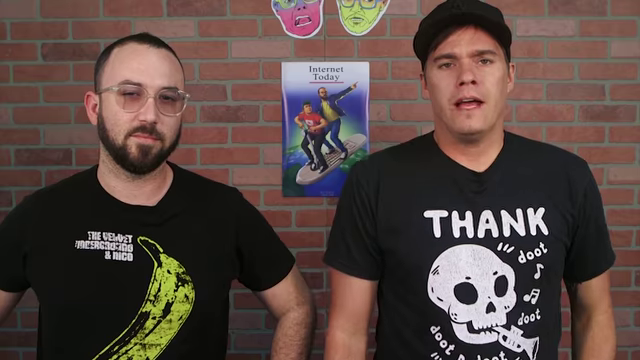

In [4]:
import jsonlines 
import cv2
import json_numpy
import pprint
from PIL import Image

frames_array = []
with jsonlines.open('./test_sample_generation/dataset.jsonl') as reader:
    for obj_idx, obj in enumerate(reader):
        test_sample = obj

        # pprint.pprint(test_sample.keys())
        print("filename: ", test_sample['filename'])
        # print("segment_frames: ", json_numpy.loads(test_sample['segment_frames'][0]))
        
        for frame in test_sample['segment_frames']:
            frames_array.append(json_numpy.loads(frame))
        break

frames_array[0] = cv2.cvtColor(frames_array[0], cv2.COLOR_BGR2RGB)
display(Image.fromarray(frames_array[0]))

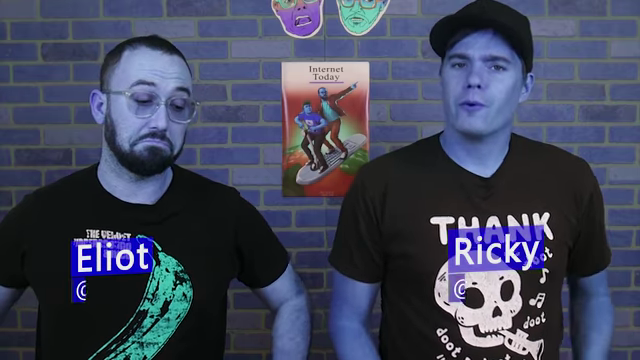

In [14]:
display(Image.fromarray(frames_array[1]))

In [15]:
import pathlib

# Convert: /tmp/parallel_10   into:   
#          /tmp/parallel_10_clip_dataset.jsonl
video_input_dir = pathlib.Path("/tmp/parallel_10")
json_output_path =  os.path.join(video_input_dir.parent, video_input_dir.stem) + '_clip.jsonl'
str(json_output_path)

'/tmp/parallel_10_clip.jsonl'